In [ ]:
# install verdict
!uv pip install verdict --system

> [**LMUnit: Fine-grained Evaluation with Natural Language Unit Tests**](https://arxiv.org/abs/2412.13091)  
> Jon Saad-Falcon, Rajan Vivek, William Berrios, Nandita Shankar Naik, Matija Franklin, Bertie Vidgen, Amanpreet Singh, Douwe Kiela, Shikib Mehri  
> 2024

We implement a portion of the LMUnit Case Study and reproduce results from Table 8.

In [6]:
from verdict import Layer, Pipeline, Unit
from verdict.schema import Schema

from typing import List, Any

NUM_SUB_TASKS = 4

INSTRUCTION = "How does the integration of healthcare analytics with electronic health records (EHRs) and the establishment of common technical standards contribute to improving patient care?"
RESPONSES = [
    "The integration of healthcare analytics with electronic health records (EHRs) and the establishment of common technical standards significantly contribute to improving patient care by providing a more coordinated, efficient, and data-driven approach to healthcare delivery...",
    "**Integration of Healthcare Analytics with Electronic Health Records (EHRs)**\n * Enables the collection, aggregation, and analysis of vast amounts of clinical data from diverse sources, including EHRs, medical devices, and laboratory results.\n * Provides insights and analytics that help identify trends, predict outcomes, and improve patient care."
]

In particular, we decompose the following pairwise decision into sub-questions. We then ask a follow-up LLM to judge each of these sub-questions and aggregate results to choose the better response.

In [7]:
class RubricUnit(Unit):
    class ResponseSchema(Schema):
        class SubQuestion(Schema):
            justification: str
            sub_question: str

        thinking: str
        sub_questions: List[SubQuestion]

    def validate(self, input, response: ResponseSchema):
        assert len(response.sub_questions) == NUM_SUB_TASKS, f"Expected {NUM_SUB_TASKS} sub-tasks, got {len(response.sub_tasks)}"

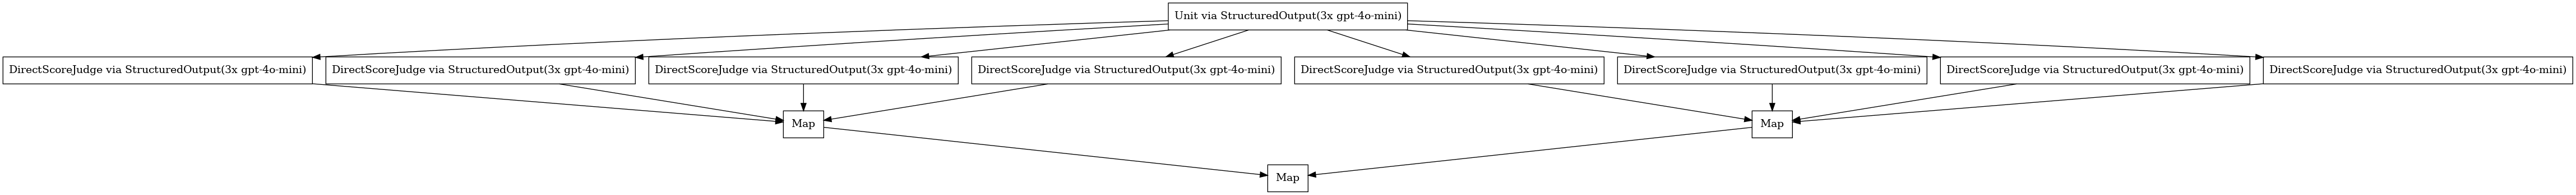

In [16]:
from verdict.common.judge import JudgeUnit
from verdict.scale import BooleanScale
from verdict.transform import MapUnit

# generate the sub-questions/unit tests
pipeline = Pipeline() \
    >> RubricUnit().prompt(f"""
        Generate {NUM_SUB_TASKS} sub-questions/unit tests to help decide which of the following <response>s to the following <instruction> is better.

        <instruction>{INSTRUCTION}</instruction>
        <response_1>{RESPONSES[0]}</response_1>
        <response_2>{RESPONSES[1]}</response_2>
    """) \
    >> Layer([
        # LLM judge for each question, run independently for each response
        Layer([
            JudgeUnit(BooleanScale(), explanation=True).prompt(f"""
                {{previous.sub_questions[{question_idx}].sub_question}}
    
                <instruction>{INSTRUCTION}</instruction>
                <response>{RESPONSES[response_idx]}</response>
            """)
        for question_idx in range(NUM_SUB_TASKS)]) \
        # sum up the number PASSED
        >> MapUnit(lambda judges: Schema.of(points=sum(judge.score for judge in judges)))
    for response_idx in range(2)]) \
    >> MapUnit(lambda responses: Schema.of(choice='1' if responses[0].points >= responses[1].points else '2'))
    # pick response with highest number of points

pipeline.plot()

In [17]:
response, _ = pipeline.run()

## Results

Let's take a look at the generated sub-questions/unit tests.

In [18]:
for idx, item in enumerate(response['Pipeline_root.block.unit[Unit]_sub_questions']):
    print(f"{idx+1}. {item['sub_question']}")

1. Does the response clearly articulate the mechanisms through which healthcare analytics and EHR integration improve patient care?
2. Does the response provide a detailed explanation of how healthcare analytics and EHRs work together to enhance patient outcomes?
3. Is the information presented in the response directly relevant to the question of improving patient care through integration and standards?
4. Does the response comprehensively cover various benefits of integrating healthcare analytics with EHRs and establishing common standards?


We can also inspect how each response performed on the unit tests.

In [35]:
for response_idx in range(2):
    print(f"### Response {response_idx+1} ###\n{RESPONSES[response_idx]}")
    print()
    for question_idx in range(NUM_SUB_TASKS):
        question = response['Pipeline_root.block.unit[Unit]_sub_questions'][question_idx]['sub_question']
        score = response[f'Pipeline_root.block.unit[Unit].block.layer[{response_idx}].block.layer[{question_idx}].unit[DirectScoreJudge]_score']
        print(f"\t{question_idx+1}. {question} [{'PASSED' if score else 'FAILED'}]")
    print()
    print()

### Response 1 ###
The integration of healthcare analytics with electronic health records (EHRs) and the establishment of common technical standards significantly contribute to improving patient care by providing a more coordinated, efficient, and data-driven approach to healthcare delivery...

	1. Does the response clearly articulate the mechanisms through which healthcare analytics and EHR integration improve patient care? [PASSED]
	2. Does the response provide a detailed explanation of how healthcare analytics and EHRs work together to enhance patient outcomes? [FAILED]
	3. Is the information presented in the response directly relevant to the question of improving patient care through integration and standards? [PASSED]
	4. Does the response comprehensively cover various benefits of integrating healthcare analytics with EHRs and establishing common standards? [PASSED]


### Response 2 ###
**Integration of Healthcare Analytics with Electronic Health Records (EHRs)**
 * Enables the co